<a href="https://colab.research.google.com/github/atreyat12/Mechanistic_Interpretability/blob/main/Mechanistic_interp_sin_curve_AT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #11
### Mechanistic Interpretability
### Atreya Tadepalli

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://colab.research.google.com/github/yourGHName/yourREPOName/blob/yourBranchName/yourFileName.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

# Introduction

In this project, I sought to better understand: is a neural network with limited layers able to track a sin wave? I wanted to make the task slightly more complex, and added a layer thinking that this would improve the neural network's power to detect a pattern. However, perhaps this complicated the process, and resulted in inaccurate predictions of the wave.

### Data Generation

I was really curious to see if this model is able to take on slightly more complex functions, and what this spells for the feature representation within the neural network. Specifically, I am curious about the model being able to learn a sinusoidal curve (y=sin(x)). To do so, I generate samples of the sin function using PyTorch.

To do so , I reference ChatGPT to develop the code to generate sin curve samples.
(Citation: the below code was generated using ChatGPT on 8:32 PM on November 12, 2025, just the method and not the subsequent code).

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import math

In [18]:
def generate_sine_data(n_samples=10000, x_min=-2*math.pi, x_max=2*math.pi, noise_std=0.01):
    #This starts with a uniform representation of x broken into 10000 samples
    X = torch.empty(n_samples, 1).uniform_(x_min, x_max)

    # This slightly throws off the interpretations, assuming the expected value
    #of the noise is 0.
    y = torch.sin(X) + noise_std * torch.randn_like(X)

    return X, y

X_train, y_train = generate_sine_data(5000)
X_val, y_val = generate_sine_data(1000)

### Build a Tiny Model

The multilayer perceptron model makes use of Dr. Bent's starter notebook to construct the toy model. I have just revised the name, and given that only one input is provided for the model to tune its weights and biases, I have updated that here. Additionally, rounded accuracy is not necessary since this is not a classification task, so absolute error and squared error would be the best loss metrics to report. The model makes use of MSE in order to tune and calibrate the weights.

I tried using just one hidden layer, but this did not do a great job of predicting the sin curve, so I have revised to incorporate two hidden layers. Given that each x is just one value, the Class is updated so that it only takes in one value.

Using Claude, I applied sin rather than ReLU- I previously used tanh given that tanh is smooth and bounded rather than ReLU, which is comprised of piecewise linear functions, but this did not work well either. Therefore, I am using a Sinusoidal pattern and hoping that approximates the function well.  (Citation: the sin code lines and associated paramters were generated using ChatGPT on 2:28 PM on November 13, 2025).

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Updated Model for Regression
class SineValueMLP(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h1 = torch.sin(self.fc1(x))
        h2 = torch.sin(self.fc2(h1))
        out = self.fc3(h2)
        return out, (h1, h2)

# Instantiate model
model = SineValueMLP(hidden_dim=32)
print(model)

# Convert targets to float (regression labels)
y_train_reg = y_train.float().unsqueeze(1)
y_val_reg = y_val.float().unsqueeze(1)

# Training loop with MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

losses = []
for epoch in range(500):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train_reg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

# Evaluation: Mean Absolute Error + Rounded Accuracy
model.eval()
with torch.no_grad():
    preds, _ = model(X_val)
    mae = torch.abs(preds - y_val_reg).mean().item()
    rounded_preds = torch.round(preds).squeeze().long()
    accuracy = (rounded_preds == y_val).float().mean().item()

print(f"Validation MAE: {mae:.2f}")


SineValueMLP(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([5000, 1, 1])) that is different to the input size (torch.Size([5000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Final training loss: 0.5061168074607849
Validation MAE: 0.64


### Print Activations of a sample input

Using the code provided by Dr. Bent, I will now attempt to see the hidden layer activations when trying to predict the y value associated with a provided x. I am trying to use pi/2, which would translate to a sin value of 1.

In [20]:
val=math.pi/2
with torch.no_grad():
    sample_input = torch.tensor([[val]], dtype=torch.float32)
    logits, hidden = model(sample_input)

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logits: {logits}")
rounded = math.sin(val)-logits.item()
print(f"Error in prediction: {rounded}")


Sample Input: tensor([[1.5708]])
Hidden Layer Activations: (tensor([[-0.6336,  0.2024, -0.9999, -0.8852,  0.3289, -0.9010,  0.4060, -0.9362,
         -0.9920, -0.8790,  0.9705, -0.1573,  0.0229, -0.9941,  0.1111, -0.3006,
          0.6127, -0.3365,  0.9708, -0.7131, -0.9563, -0.9804, -0.6952,  0.3216,
          0.8794, -0.9505,  0.1386,  0.5378, -0.5620, -0.9960,  0.3990, -0.1494]]), tensor([[ 0.0849, -0.2185, -0.4047, -0.4380,  0.0932,  0.0090, -0.3594,  0.6165,
          0.0024, -0.4714,  0.0588, -0.2779, -0.4077,  0.3582,  0.1615,  0.4393,
         -0.5434, -0.1023, -0.2725, -0.5978, -0.0155, -0.9486, -0.6208,  0.3043,
         -0.4109, -0.0240,  0.0917, -0.1832, -0.0054, -0.2708, -0.4168, -0.0500]]))
Output Logits: tensor([[0.0056]])
Error in prediction: 0.994373694062233


Despite applying a sinusoidal prediction model, it appears this model still does a poor job of approximating the sin function even after training. As such, I will proceed with interpreting this model, even though I am aware of its poor performance.

## Part 2 (Explore)

Given the model and architecture is markedly different than the one provided in the starter notebook, I have inquired with Claude on how to perform part 2 of the analysis, and specifically understand the weights, and which parts of the network are responsive to specific features. (Citation: the below five code blocks were generated using Claude on 2:44 PM on November 13, 2025).

### Part 1 - Weights Inspection

We'd like to first understand which weights carry importance in each layer.

In [21]:
def inspect_weights(model):
    """Visualize all layer weights and biases"""
    print("="*60)
    print("WEIGHT INSPECTION")
    print("="*60)

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Model Weights Visualization', fontsize=16)

    # Layer 1 weights
    w1 = model.fc1.weight.data.numpy()  # Shape: (32, 1)
    b1 = model.fc1.bias.data.numpy()    # Shape: (32,)

    axes[0, 0].hist(w1.flatten(), bins=30, edgecolor='black')
    axes[0, 0].set_title('FC1 Weights Distribution')
    axes[0, 0].set_xlabel('Weight Value')
    axes[0, 0].set_ylabel('Frequency')

    axes[1, 0].scatter(range(len(w1)), w1.flatten(), alpha=0.6)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1, 0].set_title('FC1 Weight Values (input→hidden1)')
    axes[1, 0].set_xlabel('Neuron Index')
    axes[1, 0].set_ylabel('Weight')

    # Layer 2 weights
    w2 = model.fc2.weight.data.numpy()  # Shape: (32, 32)

    im = axes[0, 1].imshow(w2, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    axes[0, 1].set_title('FC2 Weights Heatmap (32×32)')
    axes[0, 1].set_xlabel('Hidden1 Neurons')
    axes[0, 1].set_ylabel('Hidden2 Neurons')
    plt.colorbar(im, ax=axes[0, 1])

    axes[1, 1].hist(w2.flatten(), bins=30, edgecolor='black')
    axes[1, 1].set_title('FC2 Weights Distribution')
    axes[1, 1].set_xlabel('Weight Value')

    # Layer 3 weights (output)
    w3 = model.fc3.weight.data.numpy()  # Shape: (1, 32)

    axes[0, 2].bar(range(len(w3.flatten())), w3.flatten(), alpha=0.7)
    axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[0, 2].set_title('FC3 Weights (hidden2→output)')
    axes[0, 2].set_xlabel('Hidden2 Neuron Index')
    axes[0, 2].set_ylabel('Weight')

    # Statistics
    axes[1, 2].axis('off')
    stats_text = f"""
    Layer 1 (1→32):
      Mean: {w1.mean():.4f}
      Std:  {w1.std():.4f}
      Max:  {w1.max():.4f}
      Min:  {w1.min():.4f}

    Layer 2 (32→32):
      Mean: {w2.mean():.4f}
      Std:  {w2.std():.4f}

    Layer 3 (32→1):
      Mean: {w3.mean():.4f}
      Std:  {w3.std():.4f}
    """
    axes[1, 2].text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
                     verticalalignment='center')

    plt.tight_layout()
    plt.show()

    return w1, w2, w3

### Analyzing activations

Now we'd like to understand which neurons are activated, and is there a certain pattern upon which these neurons are activating.

In [22]:
def analyze_activations(model, x_range=(-2*math.pi, 2*math.pi), n_points=100):
    """Track how activations change across input range"""
    print("\n" + "="*60)
    print("ACTIVATION ANALYSIS")
    print("="*60)

    model.eval()
    x_vals = torch.linspace(x_range[0], x_range[1], n_points).unsqueeze(1)

    with torch.no_grad():
        outputs, (h1_acts, h2_acts) = model(x_vals)

    # Convert to numpy
    x_np = x_vals.squeeze().numpy()
    h1_np = h1_acts.numpy()  # Shape: (n_points, 32)
    h2_np = h2_acts.numpy()  # Shape: (n_points, 32)
    out_np = outputs.squeeze().numpy()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot output vs true sine
    axes[0, 0].plot(x_np, out_np, label='Model Output', linewidth=2)
    axes[0, 0].plot(x_np, np.sin(x_np), '--', label='True sin(x)', linewidth=2)
    axes[0, 0].set_xlabel('Input x')
    axes[0, 0].set_ylabel('Output')
    axes[0, 0].set_title('Model Output vs True Function')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Hidden layer 1 activations (show subset)
    for i in range(min(8, h1_np.shape[1])):
        axes[0, 1].plot(x_np, h1_np[:, i], alpha=0.7, label=f'N{i}' if i < 8 else '')
    axes[0, 1].set_xlabel('Input x')
    axes[0, 1].set_ylabel('Activation')
    axes[0, 1].set_title('Hidden Layer 1 Activations (first 8 neurons)')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)

    # Hidden layer 2 activations (show subset)
    for i in range(min(8, h2_np.shape[1])):
        axes[1, 0].plot(x_np, h2_np[:, i], alpha=0.7, label=f'N{i}' if i < 8 else '')
    axes[1, 0].set_xlabel('Input x')
    axes[1, 0].set_ylabel('Activation')
    axes[1, 0].set_title('Hidden Layer 2 Activations (first 8 neurons)')
    axes[1, 0].legend(loc='upper right')
    axes[1, 0].grid(True, alpha=0.3)

    # Activation heatmap for all neurons in layer 2
    im = axes[1, 1].imshow(h2_np.T, aspect='auto', cmap='RdBu',
                           extent=[x_range[0], x_range[1], 0, h2_np.shape[1]])
    axes[1, 1].set_xlabel('Input x')
    axes[1, 1].set_ylabel('Neuron Index')
    axes[1, 1].set_title('Hidden Layer 2 Activation Heatmap')
    plt.colorbar(im, ax=axes[1, 1], label='Activation Value')

    plt.tight_layout()
    plt.show()

    return x_np, h1_np, h2_np, out_np

### Finding meaningful neurons

I was surprised to see that we capture meaning here by correlation associated with the sin curve. In each instance in the first layer, we find that the predicted values closely resemble a sin wave, but are not aligned on periodicity.

In [23]:
def find_meaningful_neurons(model, x_range=(-2*math.pi, 2*math.pi), n_points=100):
    """Identify neurons with interpretable behavior"""
    print("\n" + "="*60)
    print("MEANINGFUL NEURON DETECTION")
    print("="*60)

    model.eval()
    x_vals = torch.linspace(x_range[0], x_range[1], n_points).unsqueeze(1)

    with torch.no_grad():
        outputs, (h1_acts, h2_acts) = model(x_vals)

    x_np = x_vals.squeeze().numpy()
    h1_np = h1_acts.numpy()
    h2_np = h2_acts.numpy()
    true_sin = np.sin(x_np)

    # Analyze correlation with sine wave
    print("\nLayer 1 Neurons - Correlation with sin(x):")
    print("-" * 50)
    h1_correlations = []
    for i in range(h1_np.shape[1]):
        corr = np.corrcoef(h1_np[:, i], true_sin)[0, 1]
        h1_correlations.append((i, corr))

    h1_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    print("Top 5 most correlated neurons:")
    for i, (neuron_idx, corr) in enumerate(h1_correlations[:5]):
        print(f"  Neuron {neuron_idx:2d}: correlation = {corr:+.4f}")

    print("\nLayer 2 Neurons - Correlation with sin(x):")
    print("-" * 50)
    h2_correlations = []
    for i in range(h2_np.shape[1]):
        corr = np.corrcoef(h2_np[:, i], true_sin)[0, 1]
        h2_correlations.append((i, corr))

    h2_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    print("Top 5 most correlated neurons:")
    for i, (neuron_idx, corr) in enumerate(h2_correlations[:5]):
        print(f"  Neuron {neuron_idx:2d}: correlation = {corr:+.4f}")

    # Visualize top neurons
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Most Meaningful Neurons', fontsize=16)

    # Plot top 3 from layer 1
    for i in range(3):
        neuron_idx, corr = h1_correlations[i]
        axes[0, i].plot(x_np, h1_np[:, neuron_idx], label=f'Neuron {neuron_idx}', linewidth=2)
        axes[0, i].plot(x_np, true_sin, '--', alpha=0.5, label='sin(x)')
        axes[0, i].set_title(f'Layer 1, N{neuron_idx} (ρ={corr:.3f})')
        axes[0, i].set_xlabel('Input x')
        axes[0, i].set_ylabel('Activation')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

    # Plot top 3 from layer 2
    for i in range(3):
        neuron_idx, corr = h2_correlations[i]
        axes[1, i].plot(x_np, h2_np[:, neuron_idx], label=f'Neuron {neuron_idx}', linewidth=2)
        axes[1, i].plot(x_np, true_sin, '--', alpha=0.5, label='sin(x)')
        axes[1, i].set_title(f'Layer 2, N{neuron_idx} (ρ={corr:.3f})')
        axes[1, i].set_xlabel('Input x')
        axes[1, i].set_ylabel('Activation')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return h1_correlations, h2_correlations

### Input Sensitivity

This is valuable to understand how the output varies based on the input provided for each neuron.

In [24]:
def input_sensitivity_analysis(model, test_inputs=None):
    """See how activations respond to different inputs"""
    print("\n" + "="*60)
    print("INPUT SENSITIVITY ANALYSIS")
    print("="*60)

    if test_inputs is None:
        test_inputs = [0, math.pi/4, math.pi/2, 3*math.pi/4, math.pi,
                       -math.pi/2, -math.pi]

    model.eval()

    results = []
    for x_val in test_inputs:
        x_tensor = torch.tensor([[x_val]], dtype=torch.float32)
        with torch.no_grad():
            out, (h1, h2) = model(x_tensor)

        results.append({
            'input': x_val,
            'output': out.item(),
            'true': math.sin(x_val),
            'h1': h1.squeeze().numpy(),
            'h2': h2.squeeze().numpy()
        })

        print(f"\nInput: {x_val:+.4f} ({x_val/math.pi:.2f}π)")
        print(f"  Output: {out.item():+.4f}  |  True: {math.sin(x_val):+.4f}  |  Error: {abs(out.item()-math.sin(x_val)):.4f}")
        print(f"  Active neurons in Layer 1: {np.sum(h1.numpy() > 0.1)}/32")
        print(f"  Active neurons in Layer 2: {np.sum(h2.numpy() > 0.1)}/32")

    # Visualize activation patterns
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    h1_matrix = np.array([r['h1'] for r in results])
    h2_matrix = np.array([r['h2'] for r in results])

    im1 = axes[0].imshow(h1_matrix, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
    axes[0].set_yticks(range(len(test_inputs)))
    axes[0].set_yticklabels([f"{x:.2f}" for x in test_inputs])
    axes[0].set_xlabel('Neuron Index')
    axes[0].set_ylabel('Input Value')
    axes[0].set_title('Layer 1 Activation Patterns')
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(h2_matrix, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
    axes[1].set_yticks(range(len(test_inputs)))
    axes[1].set_yticklabels([f"{x:.2f}" for x in test_inputs])
    axes[1].set_xlabel('Neuron Index')
    axes[1].set_ylabel('Input Value')
    axes[1].set_title('Layer 2 Activation Patterns')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

    return results

#

### Main Analysis

We combine all the previous methods and execute.

In [25]:
# ==================== 5. MAIN ANALYSIS FUNCTION ====================
def full_interpretability_analysis(model):
    """Run complete interpretability analysis"""
    print("\n" + "="*60)
    print("COMPLETE INTERPRETABILITY ANALYSIS")
    print("="*60)

    # 1. Weight inspection
    w1, w2, w3 = inspect_weights(model)

    # 2. Activation analysis
    x_np, h1_np, h2_np, out_np = analyze_activations(model)

    # 3. Find meaningful neurons
    h1_corr, h2_corr = find_meaningful_neurons(model)

    # 4. Input sensitivity
    results = input_sensitivity_analysis(model)

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

    return {
        'weights': (w1, w2, w3),
        'activations': (x_np, h1_np, h2_np, out_np),
        'correlations': (h1_corr, h2_corr),
        'sensitivity': results
    }

### Full output of previous 5 methods


COMPLETE INTERPRETABILITY ANALYSIS
WEIGHT INSPECTION


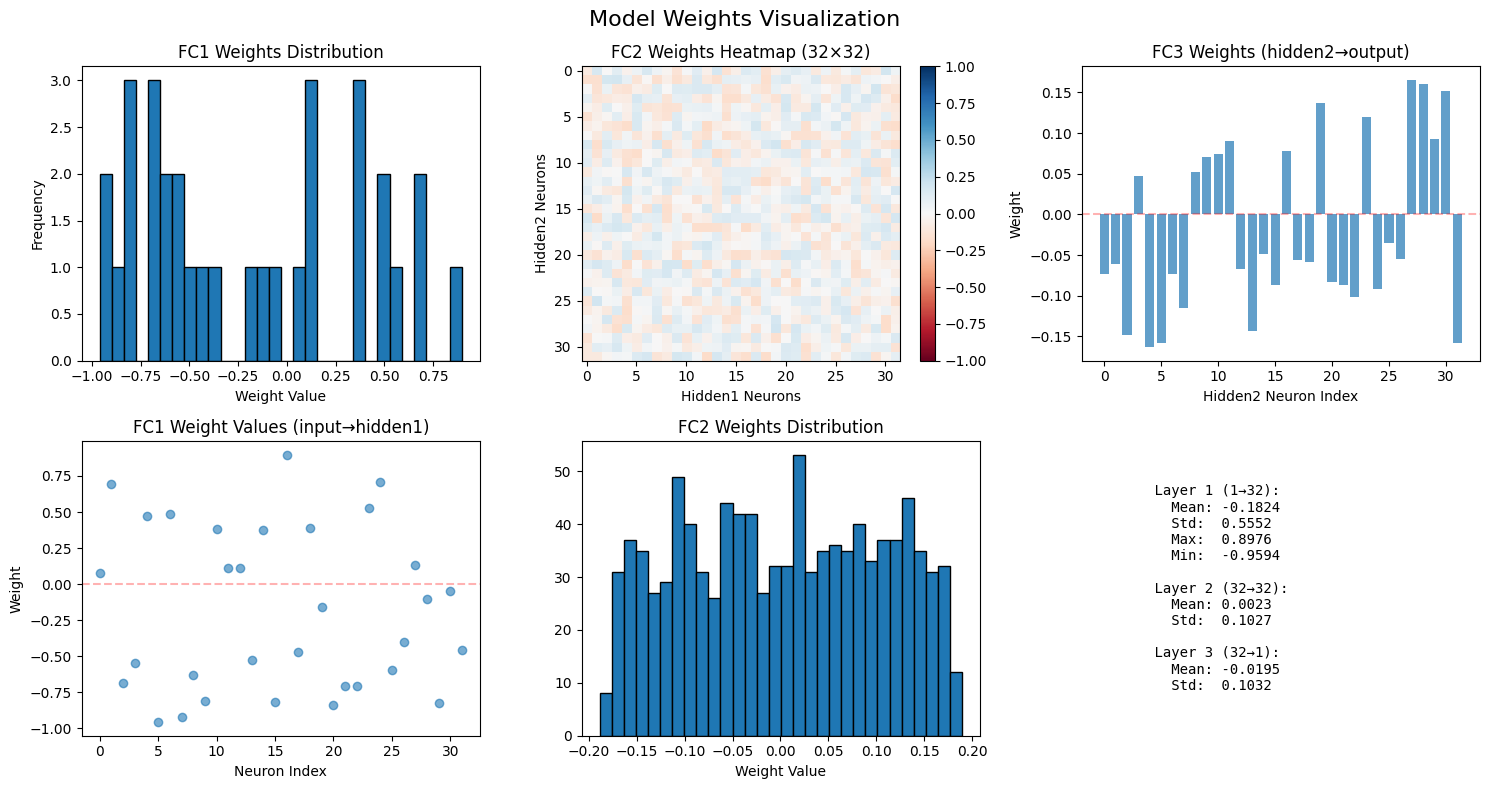


ACTIVATION ANALYSIS


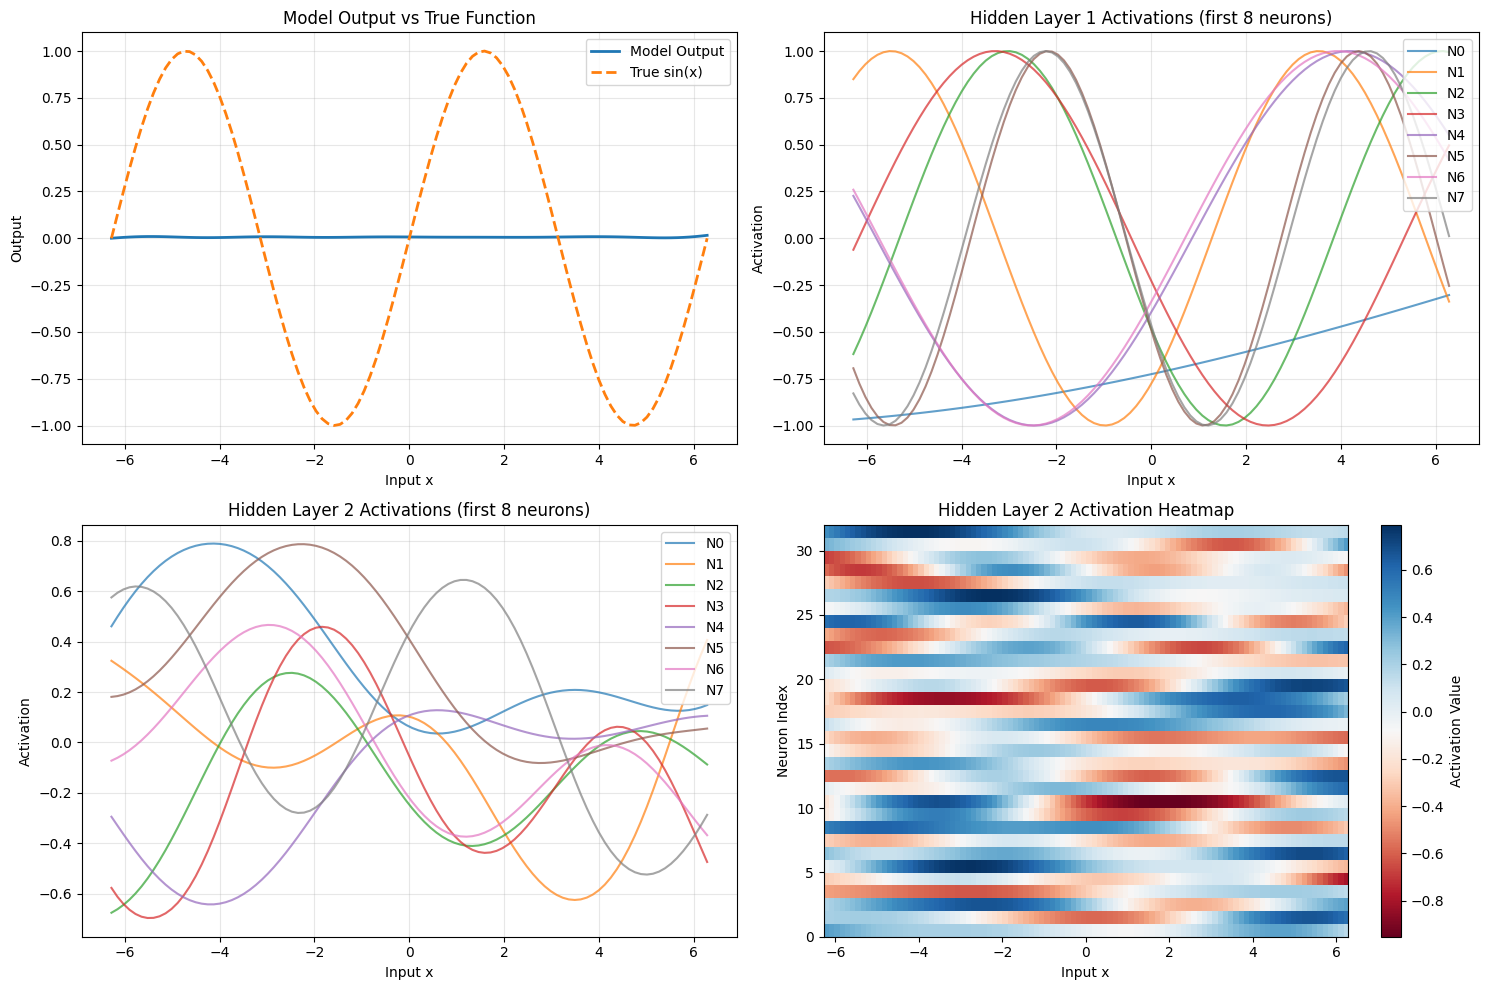


MEANINGFUL NEURON DETECTION

Layer 1 Neurons - Correlation with sin(x):
--------------------------------------------------
Top 5 most correlated neurons:
  Neuron  5: correlation = -0.8687
  Neuron 20: correlation = -0.8679
  Neuron  7: correlation = -0.8653
  Neuron 29: correlation = -0.8089
  Neuron 16: correlation = +0.7161

Layer 2 Neurons - Correlation with sin(x):
--------------------------------------------------
Top 5 most correlated neurons:
  Neuron 24: correlation = -0.9163
  Neuron 17: correlation = -0.8651
  Neuron  7: correlation = +0.8306
  Neuron  3: correlation = -0.8093
  Neuron 25: correlation = -0.7918


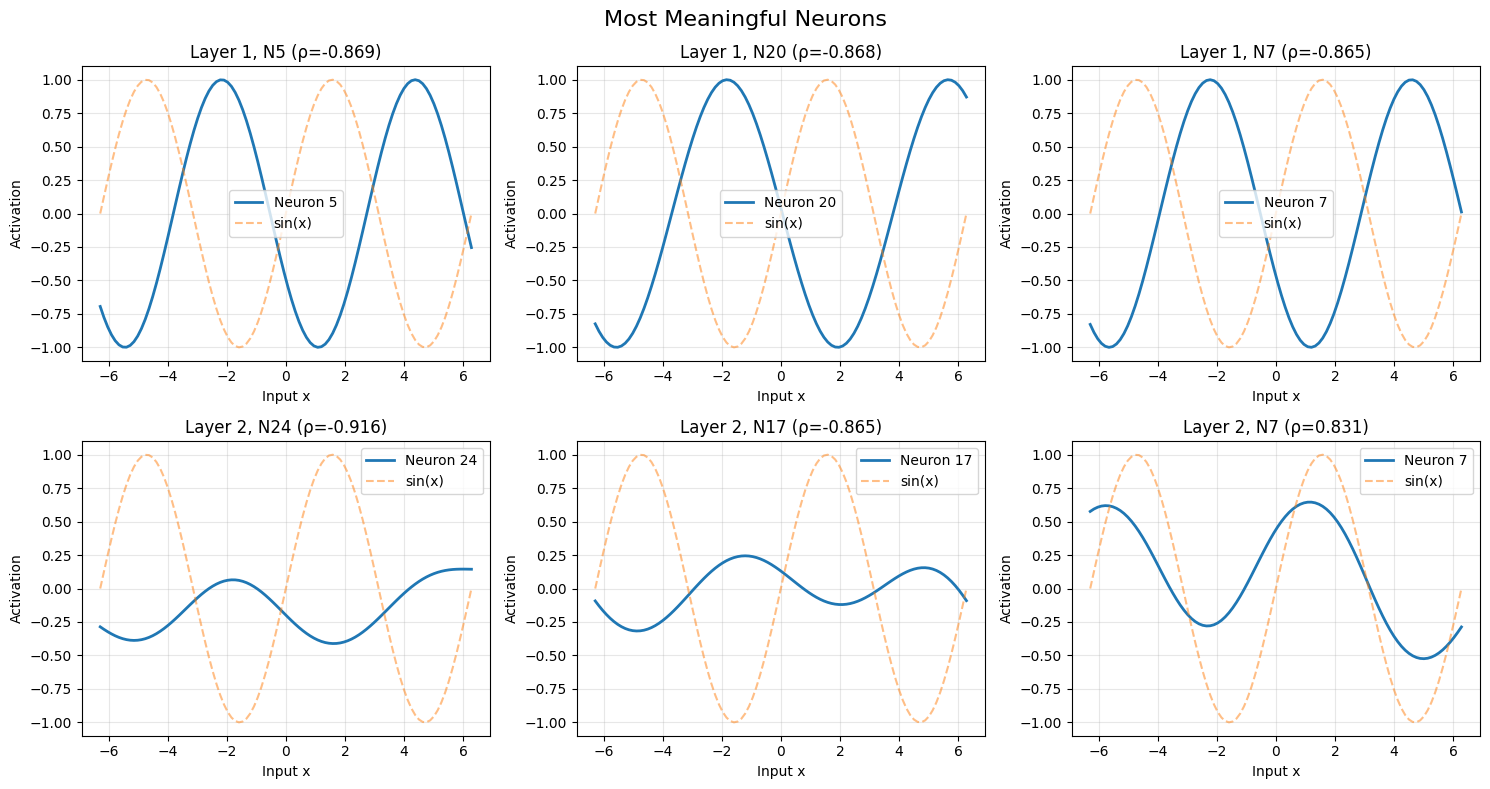


INPUT SENSITIVITY ANALYSIS

Input: +0.0000 (0.00π)
  Output: +0.0071  |  True: +0.0000  |  Error: 0.0071
  Active neurons in Layer 1: 9/32
  Active neurons in Layer 2: 14/32

Input: +0.7854 (0.25π)
  Output: +0.0059  |  True: +0.7071  |  Error: 0.7012
  Active neurons in Layer 1: 8/32
  Active neurons in Layer 2: 9/32

Input: +1.5708 (0.50π)
  Output: +0.0056  |  True: +1.0000  |  Error: 0.9944
  Active neurons in Layer 1: 12/32
  Active neurons in Layer 2: 5/32

Input: +2.3562 (0.75π)
  Output: +0.0052  |  True: +0.7071  |  Error: 0.7019
  Active neurons in Layer 1: 12/32
  Active neurons in Layer 2: 5/32

Input: +3.1416 (1.00π)
  Output: +0.0067  |  True: +0.0000  |  Error: 0.0067
  Active neurons in Layer 1: 15/32
  Active neurons in Layer 2: 9/32

Input: -1.5708 (-0.50π)
  Output: +0.0049  |  True: -1.0000  |  Error: 1.0049
  Active neurons in Layer 1: 19/32
  Active neurons in Layer 2: 19/32

Input: -3.1416 (-1.00π)
  Output: +0.0082  |  True: -0.0000  |  Error: 0.0082
  Active n

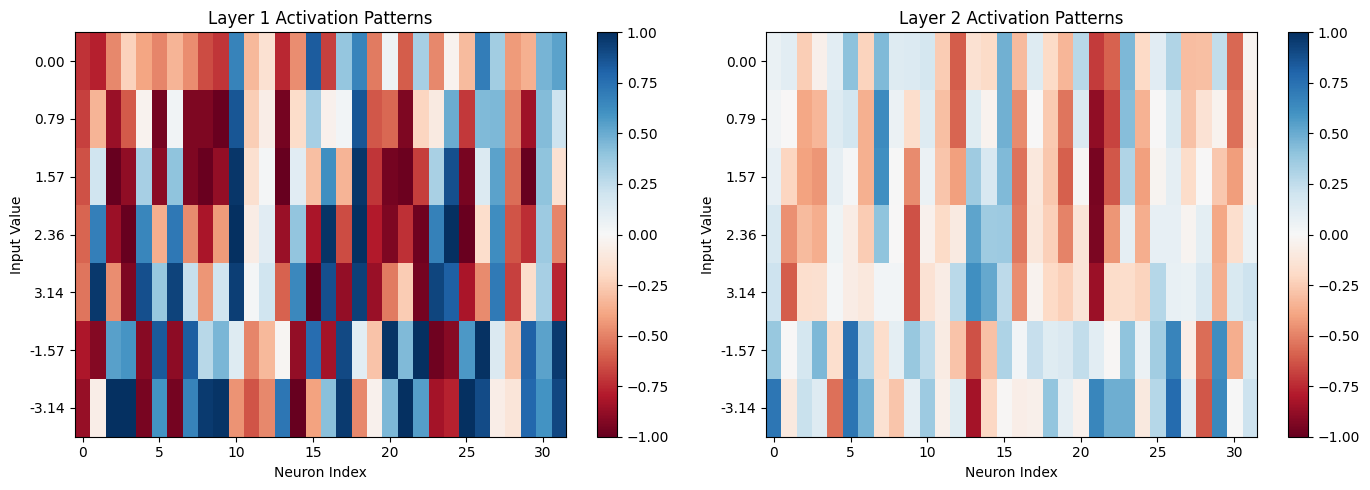


ANALYSIS COMPLETE!


In [26]:
analysis_results = full_interpretability_analysis(model)

## Interepretation of exploratory figures above

In reviewing the above figures, it becomes abundantly clear that despite the strong, correlated performance of certain neurons in tandem with the sin curve, the number of neurons contributing the final output muddles the signal and produces a poor output. In order, I will review each series of charts before arriving at mechanistic hypotheses.

From a preliminary glance, it appears that the first layer's interpretations are more conclusive than that of the second layer's weightage. We can tell this based on the concentration of neurons with negative weights, while there appears to be fewer neurons with 0 weight. To the contrary, with a uniform distribution across the weightage spectrum, it appears that FC2's weights are scattered in importance, and perhaps responsible for contributing noise to the final output and signal.This is further corroborated by the heatmap, in which there is no strong signal associated with FC2. On the other hand, FC1 presents strong weights contributing to the signal, such as neurons 5,6, and 16 which have weight magnitudes all approaching 1.

When we look at the activation maps, we can see that among the first 8 neurons (done to not overcomplicate the activation charts), there are a few neurons especially in layer FC1 that closely resemble the sin curve. The second neuron (straight line) is not one of these, but others, such as Neuron 4 (N3), adhere very closely to the sin curve. With this being said, it is surprising how despite individual neurons being strongly correlated with the intended output, the cumulative sum of weights results in a straight line that does not resemble the sin curve. When reviewing the heatmap (4th graphic), it is interesting to see neurons which capture the fluctuation of the sin curve and accordingly vary from positive to negative multiple times during the interval range, such as Neurons 8 and 29.

In looking at the most significant neurons, we utilize correlation with the sin curve and highlight the top 3 neurons in order of correlation. Overall, it appears that these neurons are able to capture the amplitude associated with the sin curve, while we see that for the neurons of hidden layer 2, few are able to capture the full magnitude associated with the sin curve. It makes me wonder if just one layer of the sinusoidal model would have been better to predict the final value, since the neuron values seem muted with the addition of the 2nd layer.

The final series of charts highlights this contrast, where the first layer displays strong intensities, while the colors for the second layer are fairly faint in comparison.

In hypothesizing, it appears that Neuron 7 of the first layer appears to be very aligned with a negative cosine wave, given a low value at x=0, and similar fluctuation like a sin wave. Additionally, I would identify the seventeenth neuron (N16) of the first layer and hypothesize this neuron is concerned indeed with the sin curve, as it has a high positive correlation (+.7161) with the sin curve most closely. In the coming section, as part of section 3, I will undertake neuron ablation for this neuron and see if it makes an impact on the prediction.

## Part 3: Explain

Here I will remove neurons to see the one that results in the strongest change to prediction. Given that my model is poorly performing, I am curious to see what this chart results in, and its true value (does it provide a meaningful conclusion with respect to predicting sin values)?

To update from the model provided earlier, I utilize Claude to tailor neuron ablation to my model and context.  (Citation: the below five code blocks were generated using Claude on 4:14 PM on November 13, 2025).

### Ablation of all neurons, sequentially

In [27]:
def ablate_all_neurons(model, test_input, layer='h1'):
    """
    Ablate each neuron one at a time and measure impact

    Returns ranking of neurons by importance
    """
    model.eval()

    # Get baseline
    with torch.no_grad():
        baseline_output, _ = model(test_input)
        baseline_pred = baseline_output.item()

    # Determine number of neurons in the layer
    if layer == 'h1':
        num_neurons = model.fc1.out_features
    elif layer == 'h2':
        num_neurons = model.fc2.out_features

    results = []

    print(f"\n{'='*60}")
    print(f"SYSTEMATIC ABLATION: All neurons in {layer.upper()}")
    print(f"{'='*60}")
    print(f"Testing {num_neurons} neurons...\n")

    for neuron_idx in range(num_neurons):
        with torch.no_grad():
            if layer == 'h1':
                h1 = torch.sin(model.fc1(test_input))
                h1[:, neuron_idx] = 0
                h2 = torch.sin(model.fc2(h1))
                ablated_output = model.fc3(h2)
            elif layer == 'h2':
                h1 = torch.sin(model.fc1(test_input))
                h2 = torch.sin(model.fc2(h1))
                h2[:, neuron_idx] = 0
                ablated_output = model.fc3(h2)

            ablated_pred = ablated_output.item()
            delta = ablated_pred - baseline_pred

            results.append({
                'neuron_idx': neuron_idx,
                'baseline': baseline_pred,
                'ablated': ablated_pred,
                'delta': delta,
                'abs_delta': abs(delta)
            })

    # Sort by absolute impact
    results.sort(key=lambda x: x['abs_delta'], reverse=True)

    # Print top 10 most important
    print("Top 10 Most Important Neurons:")
    print(f"{'Rank':<6} {'Neuron':<8} {'Impact':<12} {'New Pred':<12}")
    print("-" * 50)
    for i, r in enumerate(results[:10]):
        print(f"{i+1:<6} {r['neuron_idx']:<8} {r['delta']:+.4f}      {r['ablated']:.4f}")

    # Visualize
    visualize_ablation_results(results, layer, baseline_pred, test_input.item())

    return results


def visualize_ablation_results(results, layer, baseline, input_val):
    """Visualize ablation impact across all neurons"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    neuron_ids = [r['neuron_idx'] for r in results]
    deltas = [r['delta'] for r in results]
    abs_deltas = [r['abs_delta'] for r in results]

    # Sort back by neuron index for clearer visualization
    sorted_results = sorted(results, key=lambda x: x['neuron_idx'])
    sorted_ids = [r['neuron_idx'] for r in sorted_results]
    sorted_deltas = [r['delta'] for r in sorted_results]

    # Plot 1: Impact by neuron (sorted by neuron index)
    axes[0, 0].bar(sorted_ids, sorted_deltas, alpha=0.7, color=['red' if d < 0 else 'blue' for d in sorted_deltas])
    axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[0, 0].set_xlabel('Neuron Index')
    axes[0, 0].set_ylabel('Change in Prediction')
    axes[0, 0].set_title(f'{layer.upper()}: Impact of Ablating Each Neuron')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Plot 2: Absolute impact (sorted by importance)
    top_n = min(20, len(results))
    top_neurons = results[:top_n]
    axes[0, 1].barh([r['neuron_idx'] for r in top_neurons],
                     [r['abs_delta'] for r in top_neurons],
                     alpha=0.7, color='purple')
    axes[0, 1].set_xlabel('Absolute Change in Prediction')
    axes[0, 1].set_ylabel('Neuron Index')
    axes[0, 1].set_title(f'Top {top_n} Most Important Neurons')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # Plot 3: Distribution of impacts
    axes[1, 0].hist(deltas, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Change in Prediction')
    axes[1, 0].set_ylabel('Number of Neurons')
    axes[1, 0].set_title('Distribution of Ablation Impacts')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 4: Predictions with each neuron ablated
    ablated_preds = [r['ablated'] for r in sorted_results]
    true_val = math.sin(input_val)

    axes[1, 1].scatter(sorted_ids, ablated_preds, alpha=0.6, s=30)
    axes[1, 1].axhline(y=baseline, color='green', linestyle='-', linewidth=2, label=f'Baseline: {baseline:.3f}')
    axes[1, 1].axhline(y=true_val, color='red', linestyle='--', linewidth=2, label=f'True: {true_val:.3f}')
    axes[1, 1].set_xlabel('Neuron Index')
    axes[1, 1].set_ylabel('Prediction (with neuron ablated)')
    axes[1, 1].set_title('Predictions After Each Ablation')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



### Observation of ablation impact across different inputs

I am curious to understand what happens across each x-value when removing a neuron.

In [35]:
def ablate_across_inputs(model, layer='h1', neuron_idx=0, n_points=50):
    """
    See how ablating a neuron affects predictions across different inputs
    """
    model.eval()

    x_vals = torch.linspace(-2*math.pi, 2*math.pi, n_points).unsqueeze(1)

    baseline_preds = []
    ablated_preds = []

    for x in x_vals:
        with torch.no_grad():
            # Baseline
            baseline_out, _ = model(x)
            baseline_preds.append(baseline_out.item())

            # Ablated
            if layer == 'h1':
                h1 = torch.sin(model.fc1(x))
                h1[neuron_idx] = 0
                h2 = torch.sin(model.fc2(h1))
                ablated_out = model.fc3(h2)
            elif layer == 'h2':
                h1 = torch.sin(model.fc1(x))
                h2 = torch.sin(model.fc2(h1))
                h2[neuron_idx] = 0
                ablated_out = model.fc3(h2)

            ablated_preds.append(ablated_out.item())

    x_np = x_vals.squeeze().numpy()
    baseline_preds = np.array(baseline_preds)
    ablated_preds = np.array(ablated_preds)
    true_vals = np.sin(x_np)

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_np, baseline_preds, label='Baseline', linewidth=2)
    plt.plot(x_np, ablated_preds, label=f'Neuron {neuron_idx} ablated', linewidth=2, linestyle='--')
    plt.plot(x_np, true_vals, label='True sin(x)', alpha=0.5, linestyle=':')
    plt.xlabel('Input x')
    plt.ylabel('Prediction')
    plt.title(f'Effect of Ablating {layer.upper()} Neuron {neuron_idx}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    error_baseline = np.abs(baseline_preds - true_vals)
    error_ablated = np.abs(ablated_preds - true_vals)
    plt.plot(x_np, error_baseline, label='Baseline error', linewidth=2)
    plt.plot(x_np, error_ablated, label='Ablated error', linewidth=2)
    plt.xlabel('Input x')
    plt.ylabel('Absolute Error')
    plt.title('Error Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    avg_baseline_error = np.mean(error_baseline)
    avg_ablated_error = np.mean(error_ablated)

    print(f"\n{'='*60}")
    print(f"ABLATION ACROSS INPUT RANGE")
    print(f"{'='*60}")
    print(f"Layer: {layer.upper()}, Neuron: {neuron_idx}")
    print(f"Average error (baseline): {avg_baseline_error:.4f}")
    print(f"Average error (ablated):  {avg_ablated_error:.4f}")
    print(f"Change in error: {avg_ablated_error - avg_baseline_error:+.4f}")

### Applying prior two cells to visualize ablation results


SYSTEMATIC ABLATION: All neurons in H1
Testing 32 neurons...

Top 10 Most Important Neurons:
Rank   Neuron   Impact       New Pred    
--------------------------------------------------
1      29       +0.0827      0.0887
2      10       +0.0777      0.0836
3      5        -0.0678      -0.0619
4      18       -0.0603      -0.0543
5      7        +0.0508      0.0568
6      0        +0.0426      0.0485
7      20       -0.0422      -0.0362
8      30       +0.0416      0.0476
9      24       -0.0283      -0.0224
10     28       +0.0198      0.0258


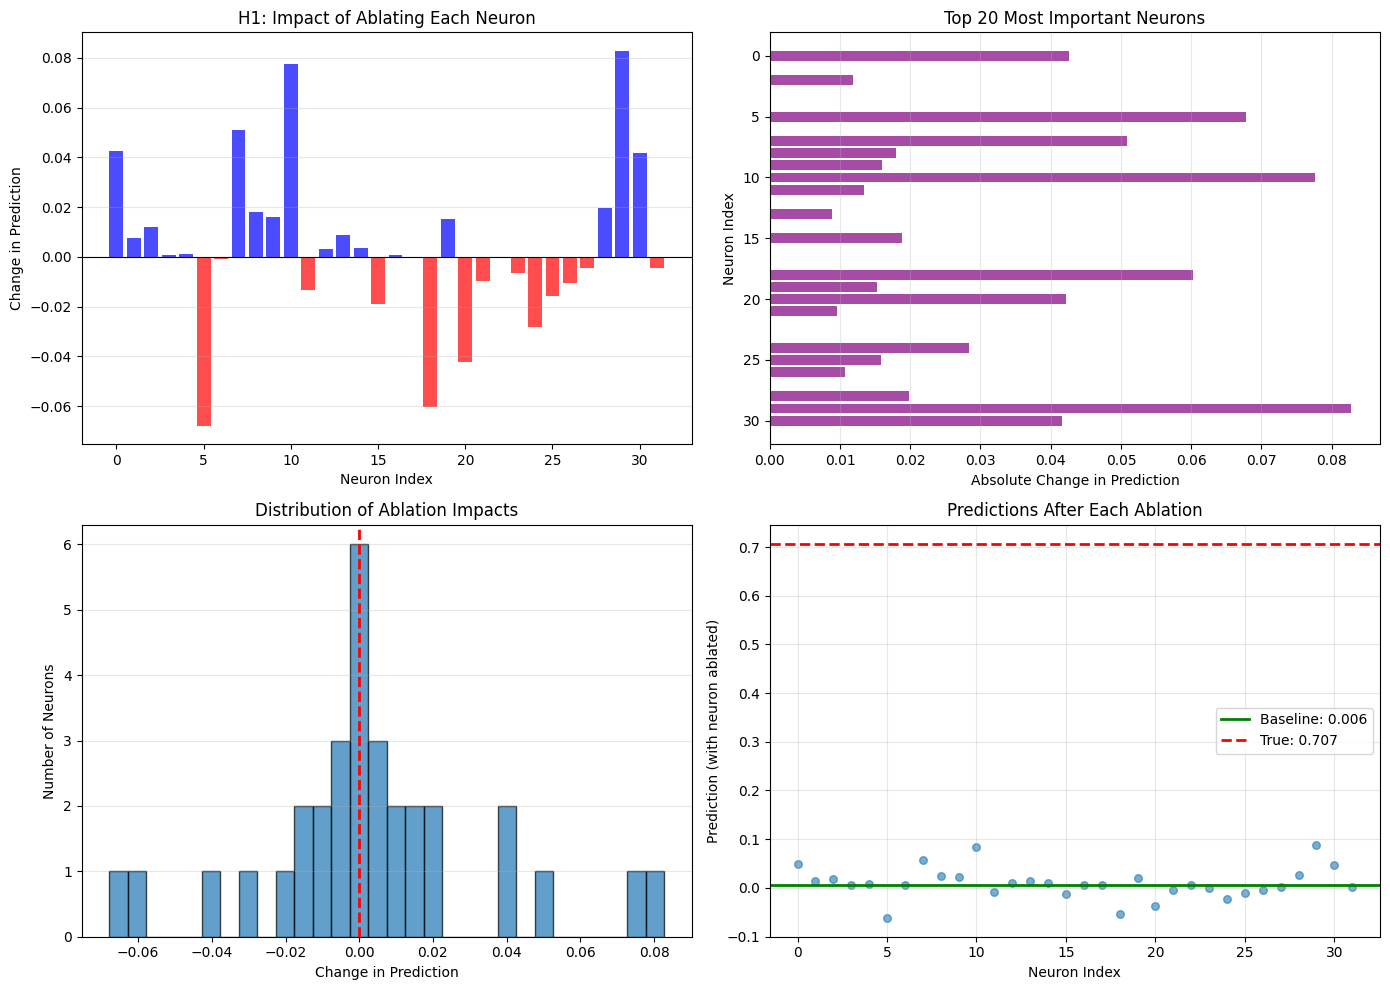


SYSTEMATIC ABLATION: All neurons in H2
Testing 32 neurons...

Top 10 Most Important Neurons:
Rank   Neuron   Impact       New Pred    
--------------------------------------------------
1      30       +0.0839      0.0898
2      21       -0.0772      -0.0713
3      19       +0.0730      0.0790
4      7        +0.0721      0.0780
5      22       -0.0686      -0.0626
6      2        -0.0568      -0.0508
7      23       -0.0509      -0.0450
8      27       +0.0487      0.0546
9      15       +0.0421      0.0481
10     12       -0.0390      -0.0330


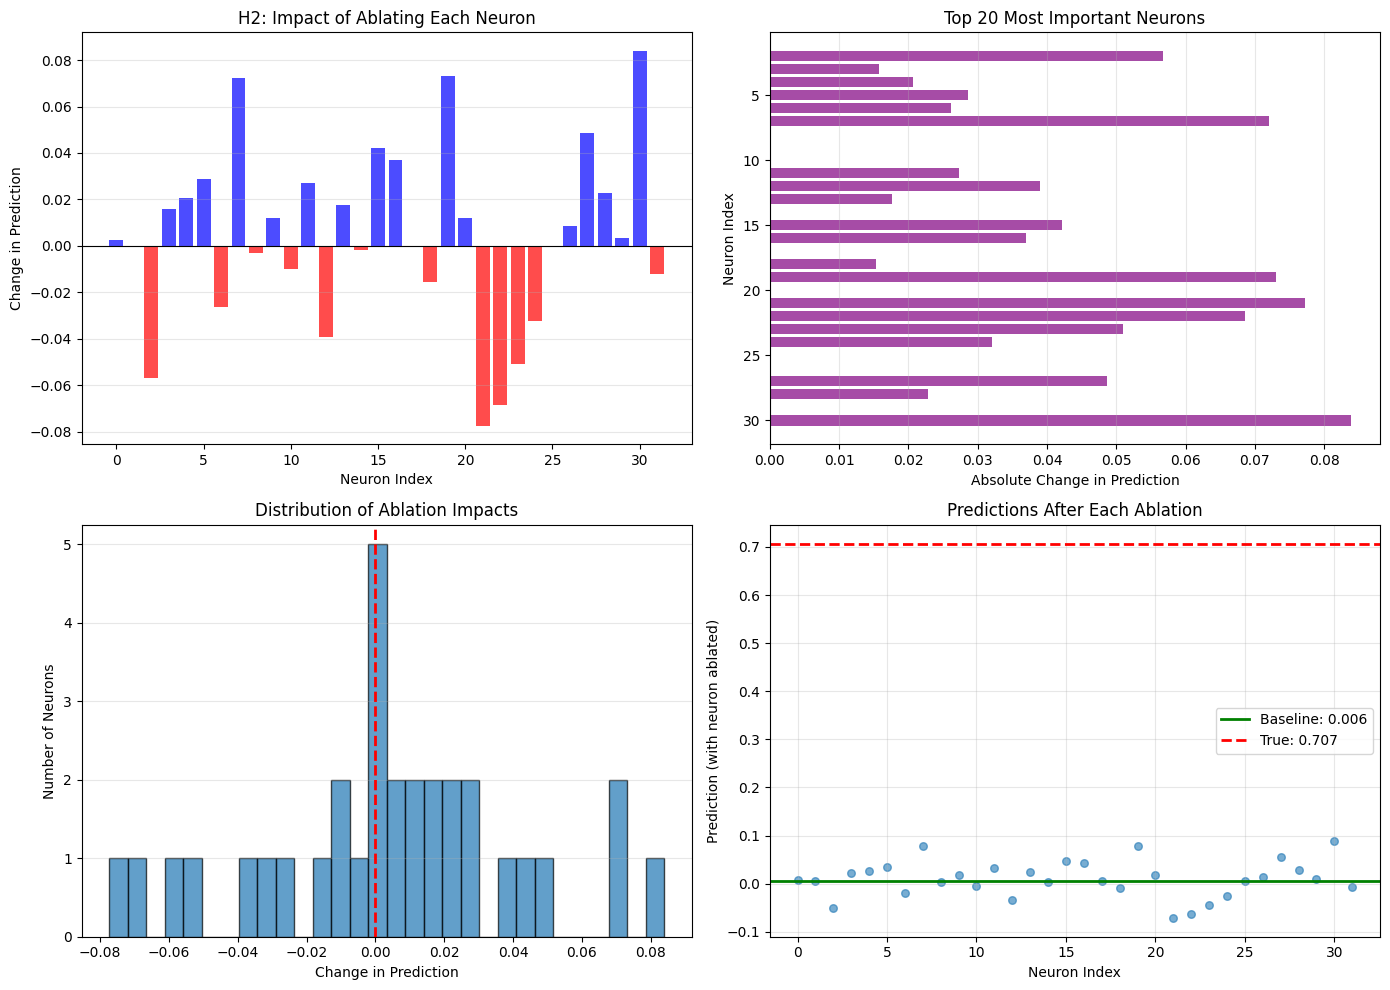

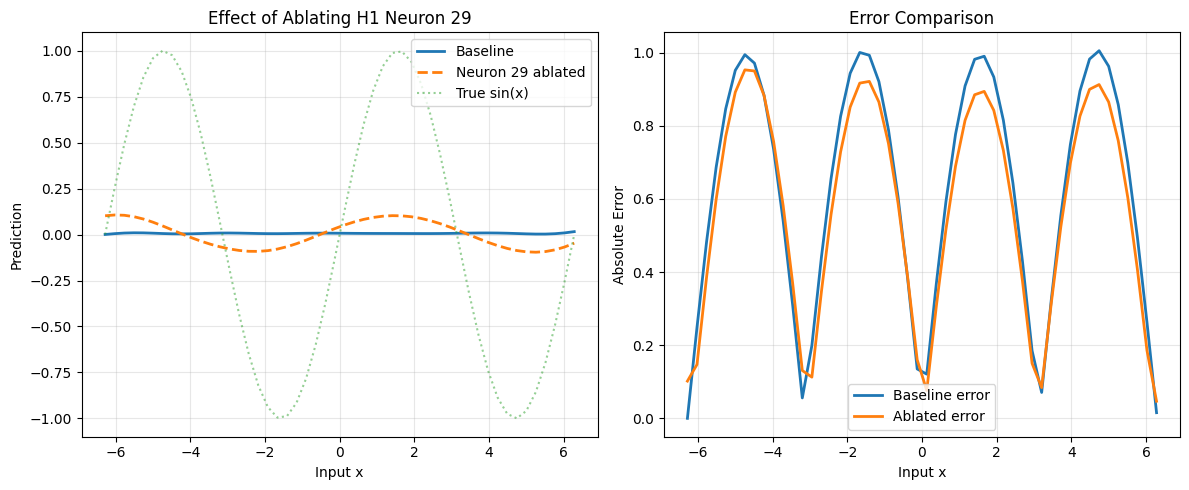


ABLATION ACROSS INPUT RANGE
Layer: H1, Neuron: 29
Average error (baseline): 0.6241
Average error (ablated):  0.5737
Change in error: -0.0505


In [37]:
test_input = torch.tensor([[math.pi/4]], dtype=torch.float32)

# 2. Find all important neurons
h1_results = ablate_all_neurons(model, test_input, layer='h1')
h2_results = ablate_all_neurons(model, test_input, layer='h2')

# 3. Test the most important neuron across all inputs
most_important_h1 = h1_results[0]['neuron_idx']
ablate_across_inputs(model, layer='h1', neuron_idx=most_important_h1)

# 4. Or run the complete workflow
#h1_results, h2_results = example_usage(model)

### Analysis of Ablation Results

***Clear and concise observation***:

In the above results, I am astonished to see the impact of removing Neuron 29 of the first hidden layer on the overall prediction. It is very interesting that Neuron 29 is almost entirely responsible for diminishing the sinusoidal periodicity associated with the graph. In particular, the last graph on the left side shows that without Neuron 29, there would be a wave representation. **Perhaps similar to regularization, I hypothesize that Neuron 29 focuses on linearization of the output.**

***Additional observations***:

Moreover, we can see once again the difference in the impact of Hidden Layer 1 versus Hidden Layer 2. In particular, we see more neurons in Hidden Layer 2 concentrated near 0 when reviewing ablation impact when compared to Hidden Layer 1, whose impacts are more distributed and scattered. Given the baseline prediction for the output with an input of (pi/4) was 0, while the true result is 0.707 we would be identifying impactful neurons as those without which the output would veer negative. For instance, I would identify Neuron 21 of the 2nd hidden layer, or Neuron 5 of Hidden Layer 1 as positive neurons whose presence helped significantly adjust the output upwards.

On the whole, however, it is difficult to truly understand the impact of each neuron, given that if I were to have chosen a different test input, the significant of each neuron would have perhaps varied greatly, due to the inability to capture the pattern associated with the sin curve.

## Part 4: Reflection

In revieiwng the model training and performance, it is really interesting to view the activation of neurons based on the input provided; perhaps even more engaging to me was the ablation of neurons to really highlight which neurons yielded the highest impact on the overall prediction result. I think perhaps because my task was so difficult for the model to engage in, the prediction inaccuracy did not completely assist in identifying the meaning and impact assocaited with each neuron. Moreover, had the model been able to accurately predict, I think we would have seen a more formative understanding of ablation, and the true impact of removing a neuron.

Based on the patterns yielded, I think perhaps two layers interfered with learning the sinusoidal curve. This can be seen from the strong patterns capturing the sin wave from neurons in the first hidden layer, but a divergence and diminution in intensity in the second hidden layer. Moreover, with this inaccuracies, it became tough to understand which feature each neuron was engaged in. From the activation maps, it appeared that some neurons, such as Neuron 5 of the first hidden layer, could be activated across the x range, while others, such as Neuron 1, seemed to be activated throughout. If I had to reattempt this, I would have chosen a less tricky task, so that the accurate results could have been achieved using a toy model, and then the impact and attention associated with the neural network could have been understood. Additionally, I think in retrospect, just one hidden layer would have been sufficient to capture the input signal and align with a sin curve.